# Anomaly detection - multiple approaches

In [1]:
# import modules and libaries:
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt

In [4]:
# load/read data:
df = pd.read_csv('ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [5]:
# check data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [6]:
# transform value from f to c:
df['value'] = round(((df['value'] - 32) * 5/9), 2)

# transform timestamp to datetime/date only:
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date

# rename columns:
df = df.rename(columns = {'timestamp':'Date', 'value':'temp (°C)'})

In [7]:
# verify changes:
df.head()

,Date,temp (°C)
0,2013-07-04,21.04
1,2013-07-04,21.79
2,2013-07-04,21.60
3,2013-07-04,20.53
4,2013-07-04,20.71


In [8]:
# check the mean on temp:
df['temp (°C)'].mean().round(2)

21.8

<Axes: xlabel='Date', ylabel='temp (°C)'>

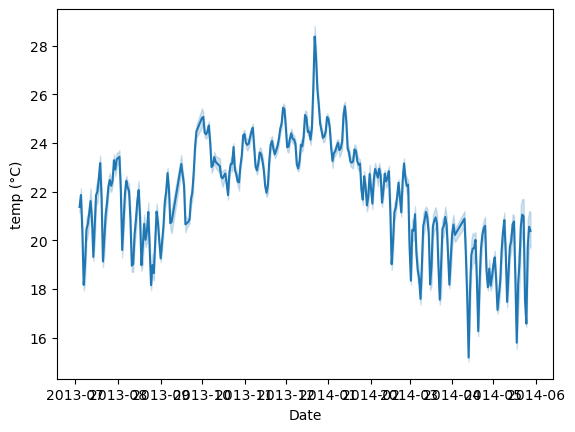

In [9]:
# plot the current data:
sns.lineplot(data = df,
             x = 'Date',
             y = 'temp (°C)')

# Approaches:

# I Prophet: Automatic Forecasting Procedure
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [10]:
# modules and libraries:
import prophet
from prophet import forecaster
from prophet import Prophet
from sklearn.model_selection import train_test_split

In [11]:
# rename columns for the purpose of the prophet:
df = df.rename(columns = {'Date':'ds', 'temp (°C)':'y'})

In [12]:
# check to see if there are any neg values:
(df['y'] < 0).any().any()

False

In [13]:
# making instance/object:
m = Prophet()

In [14]:
# traing/fit and predict the model:
df.columns = ['ds', 'y']

train, test = train_test_split(df, random_state = 42)

m.fit(train[['ds','y']])

forecast = m.predict(test)

12:45:03 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# function for detection:
def detect(forecast):
    forcast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    forcast['real'] = df['y']
    
    # main treshold:
    forcast['anomaly'] = 0 # not an anomaly
    forcast.loc[forcast['real'] > forcast['yhat_upper'], 'anomaly'] = 1 # possible outliner
    forcast.loc[forcast['real'] < forcast['yhat_lower'], 'anomaly'] = -1 # anomaly
    
    # impL
    forcast['imp'] = 0
    in_range = forcast['yhat_upper'] - forcast['yhat_lower']
    forcast.loc[forcast['anomaly'] == 1, 'imp'] = forcast['real'] - forcast['yhat_upper'] / in_range
    forcast.loc[forcast['anomaly'] == -1, 'imp'] =  forcast['yhat_lower'] - forcast['real'] / in_range
    return forcast

In [16]:
# reorder cols and call the function:
df = detect(forecast)
cols = ['ds', 'real', 'yhat', 'anomaly']
df = df[cols]

df.head()

,ds,real,yhat,anomaly
0,2013-07-04,21.04,20.926817,0
1,2013-07-04,21.79,20.926817,0
2,2013-07-04,21.60,20.926817,0
3,2013-07-04,20.53,20.926817,0
4,2013-07-04,20.71,20.926817,0


C:\Users\A427443\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


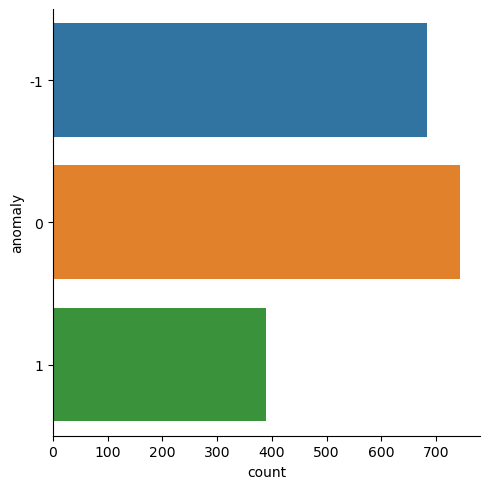

In [17]:
sns.catplot(data = df, y = "anomaly", kind = "count")

# II Scikit learn

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np

In [19]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [20]:
# fill empty NA values with mode:
titanic['age'].fillna(titanic['age'].mode()[0], inplace=True)
titanic['cabin'].fillna(titanic['cabin'].mode()[0], inplace=True)
titanic['boat'].fillna(titanic['boat'].mode()[0], inplace=True)
titanic['body'].fillna(titanic['body'].mode()[0], inplace=True)
titanic['sex'].fillna(titanic['sex'].mode()[0], inplace=True)
titanic['survived'].fillna(titanic['survived'].mode()[0], inplace=True)
titanic['home.dest'].fillna(titanic['home.dest'].mode()[0], inplace=True)

In [21]:
from scipy.stats import zscore
titanic["age_zscore"] = zscore(titanic["age"])
titanic["outlier"] = titanic["age_zscore"].apply(
  lambda x: x == 2.8
)

In [34]:
titanic.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_zscore,outlier
1305,3.0,0.0,"Zabour, Miss. Thamine",female,24.0,1.0,0.0,2665,14.454200,C23 C25 C27,C,13,1.0,"New York, NY",-0.358804,False
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5,0.0,0.0,2656,7.225000,C23 C25 C27,C,13,304.0,"New York, NY",-0.167785,False
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.225000,C23 C25 C27,C,13,1.0,"New York, NY",-0.129581,False
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0,0.0,0.0,315082,7.875000,C23 C25 C27,S,13,1.0,"New York, NY",0.023233,False
1309,NaN,0.0,NaN,male,24.0,NaN,NaN,NaN,33.295479,C23 C25 C27,NaN,13,1.0,"New York, NY",-0.358804,False


# III DBSCAN

In [23]:
titanic['fare'].fillna(titanic['fare'].mean(), inplace=True)
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

In [24]:
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_zscore,outlier
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.337500,B5,S,2,1.0,"St Louis, MO",0.023233,False
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.550000,C22 C26,S,11,1.0,"Montreal, PQ / Chesterville, ON",-2.122538,False
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.550000,C22 C26,S,13,1.0,"Montreal, PQ / Chesterville, ON",-2.039765,False
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.550000,C22 C26,S,13,135.0,"Montreal, PQ / Chesterville, ON",0.099641,False
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.550000,C22 C26,S,13,1.0,"Montreal, PQ / Chesterville, ON",-0.282396,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3.0,0.0,"Zabour, Miss. Thamine",female,24.0000,1.0,0.0,2665,14.454200,C23 C25 C27,C,13,1.0,"New York, NY",-0.358804,False
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.225000,C23 C25 C27,C,13,304.0,"New York, NY",-0.167785,False
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.225000,C23 C25 C27,C,13,1.0,"New York, NY",-0.129581,False
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0000,0.0,0.0,315082,7.875000,C23 C25 C27,S,13,1.0,"New York, NY",0.023233,False


In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
fage = pd.DataFrame(titanic, columns = ["age", "fare"])
scale = StandardScaler()
fage = scale.fit_transform(fage)

In [27]:
fage = scale.fit_transform(fage)

<Axes: xlabel='age', ylabel='fare'>

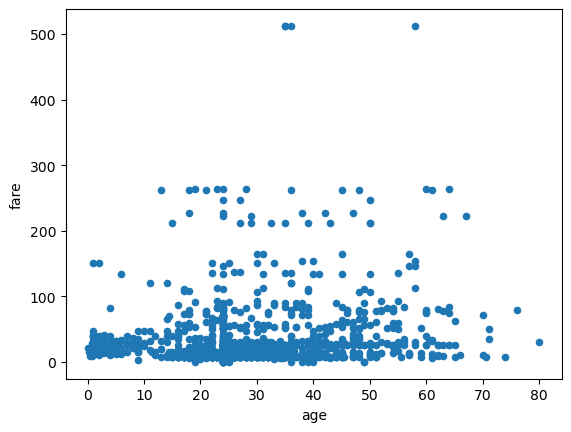

In [28]:
titanic.plot.scatter(x = "age", y = "fare")

In [29]:
from sklearn.cluster import DBSCAN
outlier = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier.fit_predict(fage)

In [30]:
clusters

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [31]:
value=-1
index = clusters.argmin()
print(" The element is at ", index)
small_num = np.min(clusters)
print("The small number is : " , small_num)
print(np.where(clusters == small_num))

 The element is at  14
The small number is :  -1
(array([ 14,  50,  66,  94, 285, 286], dtype=int64),)


C:\Users\A427443\AppData\Local\Temp\ipykernel_19676\1327957258.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = cm.get_cmap('magma_r')


<Axes: xlabel='age', ylabel='fare'>

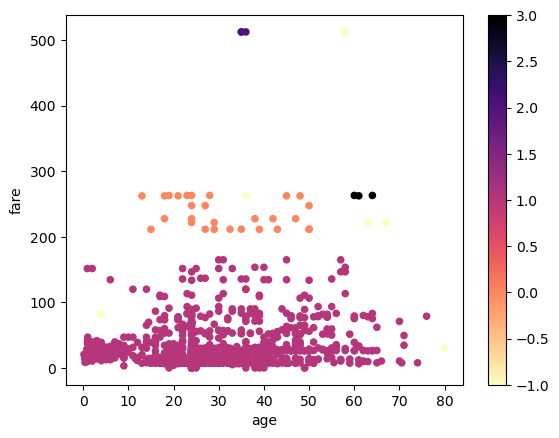

In [32]:
from matplotlib import cm
c = cm.get_cmap('magma_r')
titanic.plot.scatter(
  x = "age",
  y = "fare",
  c = clusters,
  cmap = c,
  colorbar = True
)

In [33]:
# end